https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com

# Flatiron Phase 5 Project

## Aaron Galbraith

https://www.linkedin.com/in/aarongalbraith \
https://github.com/aarongalbraith

### Submitted: November 21, 2023

## working contents

- **[functions](#functions)<br>**
- **[rough overview](#rough-overview)<br>**
- **[duplicates](#duplicates)<br>**
- **[missing values](#missing-values)<br>**
- **[contractions](#contractions)<br>**
- **[dates](#dates)<br>**
- **[ratings](#ratings)<br>**
- **[focusing on birth control](#focusing-on-birth-control)<br>**
- **[feature engineering ideas](#feature-engineering-ideas)<br>**
- **[rudimentary word cloud maker](#rudimentary-word-cloud-maker)<br>**
- **[end](#end)<br>**


## Contents

- **[Business Understanding](#Business-Understanding)<br>**
- **[Data Understanding](#Data-Understanding)**<br>
- **[Data Preparation](#Data-Preparation)**<br>
- **[Exploration](#Exploration)**<br>
- **[Modeling](#Modeling)**<br>
- **[Evaluation](#Evaluation)**<br>
- **[Recommendations](#Recommendations)<br>**
- **[Further Inquiry](#Further-Inquiry)**<br>

In [135]:
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

import html
import contractions

import re

from IPython.display import display

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV


SEED = 1979

do_grids = True

In [2]:
d1 = pd.read_csv('../data/drugsComTrain_raw.tsv', delimiter='\t', encoding='latin-1')
d2 = pd.read_csv('../data/drugsComTest_raw.tsv', delimiter='\t', encoding='latin-1')
df = pd.concat([d1,d2]).reset_index().drop(columns=['Unnamed: 0', 'index'])

# functions

In [3]:
def show_review(index):
    print(df.review.loc[index])
    display(df[df.review == df.loc[index].review][['drugName', 'condition', 'rating', 'date', 'usefulCount']])

In [4]:
def show_similar(index):
    
    count_total = df[
        (df.drugName == df.loc[index].drugName) & \
        (df.condition == df.loc[index].condition) & \
        (df.date == df.loc[index].date)
    ].review.count()
    
    count_similar = df[
        (df.drugName == df.loc[index].drugName) & \
        (df.condition == df.loc[index].condition) & \
        (df.rating == df.loc[index].rating) & \
        (df.date == df.loc[index].date)
    ].review.count()
    
    print('On', df.loc[index].date, df.loc[index].drugName, 'was reviewed', count_total, \
          'times and received a rating of', df.loc[index].rating, count_similar, 'times.\n')
    print('From that date, here are all', count_similar, 'reviews with the same rating:\n')
    for ind in df[
        (df.drugName == df.loc[index].drugName) & \
        (df.condition == df.loc[index].condition) & \
        (df.rating == df.loc[index].rating) & \
        (df.date == df.loc[index].date)
    ].index:
        print(df.loc[ind].review,'\n')
    
    print('Here is a breakdown of all the dates when reviewers gave the same drug name and condition THIS RATING:')
    display(df[
        (df.drugName == df.loc[index].drugName) & \
        (df.condition == df.loc[index].condition) & \
        (df.rating == df.loc[index].rating)
    ].date.value_counts())

# rough overview

In [5]:
df.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [6]:
df.shape

(215063, 6)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215063 entries, 0 to 215062
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   drugName     215063 non-null  object 
 1   condition    213869 non-null  object 
 2   review       215063 non-null  object 
 3   rating       215063 non-null  float64
 4   date         215063 non-null  object 
 5   usefulCount  215063 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 9.8+ MB


In [8]:
df.drugName.value_counts()

drugName
Levonorgestrel                       4930
Etonogestrel                         4421
Ethinyl estradiol / norethindrone    3753
Nexplanon                            2892
Ethinyl estradiol / norgestimate     2790
                                     ... 
Melpaque HP                             1
Cortisone                               1
Reyataz                                 1
Striant                                 1
Allergy DN PE                           1
Name: count, Length: 3671, dtype: int64

In [9]:
df.condition.value_counts()

condition
Birth Control                                   38436
Depression                                      12164
Pain                                             8245
Anxiety                                          7812
Acne                                             7435
                                                ...  
Systemic Candidiasis                                1
Wilson's Disease                                    1
unctional Gastric Disorde                           1
Sepsis                                              1
105</span> users found this comment helpful.        1
Name: count, Length: 916, dtype: int64

In [10]:
df.rating.value_counts()

rating
10.0    68005
9.0     36708
1.0     28918
8.0     25046
7.0     12547
5.0     10723
2.0      9265
3.0      8718
6.0      8462
4.0      6671
Name: count, dtype: int64

In [11]:
df.groupby('drugName').condition.nunique().value_counts()

condition
1     1869
2      782
3      334
4      195
5      122
6       83
7       52
8       51
9       38
11      20
10      19
12      19
14      18
13      18
15      11
18       8
16       6
17       5
0        4
20       3
23       3
19       3
25       2
22       2
39       1
24       1
31       1
21       1
Name: count, dtype: int64

This means that, for example, 2047 drugs treat one condition only, and 753 drugs treat two conditions, etc.

In [12]:
df.groupby('condition').drugName.nunique().value_counts()

drugName
2      188
1      166
4       78
3       72
5       44
      ... 
127      1
95       1
81       1
56       1
39       1
Name: count, Length: 71, dtype: int64

This means that 180 conditions are treatable by two drugs, etc.

In [13]:
pd.set_option("display.max_rows", None)
print(df.drugName.value_counts())
pd.set_option("display.max_rows", 10)

drugName
Levonorgestrel                                                                                      4930
Etonogestrel                                                                                        4421
Ethinyl estradiol / norethindrone                                                                   3753
Nexplanon                                                                                           2892
Ethinyl estradiol / norgestimate                                                                    2790
Ethinyl estradiol / levonorgestrel                                                                  2503
Phentermine                                                                                         2085
Sertraline                                                                                          1868
Escitalopram                                                                                        1747
Mirena                                        

A casual overview of the drug names indicates that they all seem valid.

In [14]:
pd.set_option("display.max_rows", None)
print(df.condition.value_counts())
pd.set_option("display.max_rows", 10)

condition
Birth Control                                                          38436
Depression                                                             12164
Pain                                                                    8245
Anxiety                                                                 7812
Acne                                                                    7435
Bipolar Disorde                                                         5604
Insomnia                                                                4904
Weight Loss                                                             4857
Obesity                                                                 4757
ADHD                                                                    4509
Diabetes, Type 2                                                        3362
Emergency Contraception                                                 3290
High Blood Pressure                                               

Oddly, the condition labels often (always?) omit initial 'F' and terminal 'r'. We can isolate instances of the former by searching for conditions that start with a lower case letter.

# missing values

In [15]:
len(df[df.condition.isna()])

1194

In [16]:
df.condition.fillna('missing', inplace=True)

In [17]:
len(df[df.condition == 'missing'])

1194

We noticed another condition label that was meant to indicate missing and should be accordingly changed.

In [18]:
df.condition = df.condition.apply(lambda x: 'missing' if 'Not Listed' in x else x)

In [19]:
len(df[df.condition == 'missing'])

1786

We've identified some actual missing condition labels, but we noticed there are more condition labels that seem suspicious, particularly ones that start with something other than an upper case character. Let's look at all such condition labels.

In [20]:
set(df[(~df.condition.str[0].isin(list(string.ascii_uppercase))) &
   (df.condition != 'missing')
  ].condition)

{'0</span> users found this comment helpful.',
 '100</span> users found this comment helpful.',
 '105</span> users found this comment helpful.',
 '10</span> users found this comment helpful.',
 '110</span> users found this comment helpful.',
 '11</span> users found this comment helpful.',
 '121</span> users found this comment helpful.',
 '123</span> users found this comment helpful.',
 '12</span> users found this comment helpful.',
 '135</span> users found this comment helpful.',
 '13</span> users found this comment helpful.',
 '142</span> users found this comment helpful.',
 '145</span> users found this comment helpful.',
 '146</span> users found this comment helpful.',
 '14</span> users found this comment helpful.',
 '15</span> users found this comment helpful.',
 '16</span> users found this comment helpful.',
 '17</span> users found this comment helpful.',
 '18</span> users found this comment helpful.',
 '19</span> users found this comment helpful.',
 '1</span> users found this comm

These fall into three categories. Ones that include "users found this comment helpful" should be regarded as erroneous and therefore missing.

In [21]:
df.condition = df.condition.apply(lambda x: 'missing' if 'users found' in x else x)

In [22]:
len(df[df.condition == 'missing'])

2957

 Ones that show a clipped copy of the drug name and end with a parenthesis should also be regarded as missing.

In [23]:
df.condition = df.condition.apply(lambda x: 'missing' \
                                  if x[0] not in list(string.ascii_uppercase) and \
                                  x[-1] in ['(', ')'] \
                                  else x)

In [24]:
len(df[df.condition == 'missing'])

3286

Most of the ones that show a clipped version of the condition label can possibly be restored.

In [25]:
def condition_restore(condition):
    if condition.split()[-1] in ['Disorde', 'eve', 'Shoulde', 'Cance']:
        condition = condition+'r'
    if condition.split()[0] in ['acial', 'ibrocystic', 'ungal', 'amilial', 'ailure', 'ever', \
                                'emale', 'unctional', 'actor', 'ibromyalgia', 'atigue']:
        condition = 'F'+condition
    if condition.split()[0] in ['llicular', 'llicle', 'lic', 'cal']:
        condition = 'Fo'+condition
    if condition.split()[0] in ['mance']:
        condition = 'Perfor'+condition
    if condition.split()[0] in ['zen']:
        condition = 'Fro'+condition
    if condition.split()[0] in ['mis']:
        condition = 'Dermatitis Herpetifor'+condition
    return condition

df.condition = df.condition.apply(lambda x: condition_restore(x))

Let's look at what we have left.

In [26]:
set(df[(~df.condition.str[0].isin(list(string.ascii_uppercase))) &
   (df.condition != 'missing')
  ].condition)

{'m Pain Disorder', 'me', 't Care', "von Willebrand's Disease"}

"von Willebrand's Disease" appears to be a naturally uncapitalized condition. The others have been impossible to restore and will also be regarded as missing.

In [27]:
df.condition = df.condition.apply(lambda x: 'missing' \
                                  if x[0] not in list(string.ascii_uppercase) and \
                                  x.split()[0] != 'von' \
                                  else x)

In [28]:
len(df[df.condition == 'missing'])

3293

## proposed solutions for missing values

1. For every record with a missing condition, we will assign it the condition that is most common for the drug indicated by that record.

2. Before executing solution 1, find each record's twin and use the condition label from the twin where applicable.

For now, we'll just execute solution 2.

In [29]:
drugs_w_missing_condition = list(set(df[df.condition == 'missing'].drugName))

In [30]:
len(drugs_w_missing_condition)

842

This applies to about a quarter of the drugs. We'll create a dictionary that reports the most common condition for these drugs.

In [31]:
most_common_condition = {}

for drug in drugs_w_missing_condition:
    condition = df[df.drugName == drug].condition.value_counts().idxmax()
    if condition == 'missing' and len(set(df[df.drugName == drug].condition)) > 1:
        condition = df[(df.drugName == drug) &
                       (df.condition != 'missing')
                      ].condition.value_counts().idxmax()
    proportion = round(df[df.drugName == drug].condition.value_counts(normalize=True)[0],2)
    most_common_condition[drug] = [condition, proportion]

In [32]:
most_common_condition['Viagra']

['Erectile Dysfunction', 0.87]

For example, if a review with an unlisted condition is about Viagra, we will assume the condition is Erectile Dysfunction.

In [33]:
df['condition'] = df.apply(lambda x: most_common_condition[x.drugName][0] \
                           if x.condition == 'missing' \
                           else x.condition, axis = 1)

In [34]:
len(df[df.condition == 'missing'])

105

This is how many records there are that still have no label for condition. This means the drugs indicated in these records are *only* indicated in references without an indicated condition. They may still have a "twin" records that we could match them to, but while we're skipping that solution step, there's not really anything we can do with these records, and we may as well drop them.

In [35]:
df.drop(df[df.condition == 'missing'].index, inplace=True)

# duplicates

In [36]:
df.duplicated().value_counts()

False    214956
True          2
Name: count, dtype: int64

In [37]:
df[df.duplicated()]

,drugName,condition,review,rating,date,usefulCount
178703,Levonorgestrel,Emergency Contraception,"""I had a quickie n he decided to finish it off...",1.0,"September 23, 2016",10
191001,Plan B,Emergency Contraception,"""I had a quickie n he decided to finish it off...",1.0,"September 23, 2016",10


In [38]:
df[df.review == df.review.loc[178703]]

,drugName,condition,review,rating,date,usefulCount
131531,Levonorgestrel,Emergency Contraception,"""I had a quickie n he decided to finish it off...",1.0,"September 23, 2016",10
143768,Plan B,Emergency Contraception,"""I had a quickie n he decided to finish it off...",1.0,"September 23, 2016",10
178703,Levonorgestrel,Emergency Contraception,"""I had a quickie n he decided to finish it off...",1.0,"September 23, 2016",10
191001,Plan B,Emergency Contraception,"""I had a quickie n he decided to finish it off...",1.0,"September 23, 2016",10


This is curious. The same review is recorded four times. There are two identical pairs, where the difference between the pairs is the drug name. We can drop one from each pair, but this will need to be revisited.

In [39]:
df.drop_duplicates(inplace=True)

# temporary solution for duplicate records

For the time being, we will drop records that duplicate ALL values EXCEPT drug name. This MIGHT drop some genuinely different records that happen to have the same condition, review (e.g. "It works!"), rating, date, and useful count.

In [40]:
len(df)

214956

In [41]:
df.drop(df[df.duplicated(subset=df.columns.difference(['drugName']))].index, inplace=True)

In [42]:
len(df)

128989

# further exploration of duplicates (skip for now)

The main type of duplicate we should look out for is records with duplicate reviews, as those likely indicate some kind of actual erroneous duplication. Let's see how many of those there are.

In [ ]:
len(df[df.duplicated(subset=['review'])])

That's a lot!

The other type of duplicate we should possibly be aware of is a kind of "intentional" duplicate, where a user seems to be logging multiple reviews for the same product on the same day with the same rating in some deliberate attempt to boost or bomb the product's average. let's see how many records duplicate the drug name, condition, rating, and date.

In [ ]:
len(df[df.duplicated(subset=['drugName', 'condition', 'rating', 'date'])])

That also seems like a lot. Let's explore these now.

In [ ]:
df[df.duplicated(subset=['drugName', 'condition', 'rating', 'date'])].head()

We'll use the "show_similar" function to explore these reviews that duplicate drug name

In [ ]:
show_similar(2450)

In [ ]:
show_similar(3597)

In [ ]:
show_similar(4892)

In [ ]:
show_review(183510)

In [ ]:
df[df.duplicated(subset=['drugName', 'condition', 'rating', 'date'])].rating.value_counts()

In [ ]:
df[
    (df.drugName == df.loc[8576].drugName) & \
    (df.condition == df.loc[8576].condition) & \
    (df.date == df.loc[8576].date)
    
]

In [ ]:
df[(df.drugName == 'Miconazole') & \
   (df.condition == 'Vaginal Yeast Infection') & \
   (df.rating == 1.0) & \
   (df.date == 'May 25, 2016') & \
   (df.usefulCount == 6) \
  ]

In [ ]:
show_review(8737)

In [ ]:
len(df[df.duplicated(subset=['review'])])

An enormous number of records have duplicated reviews.

In [ ]:
df.duplicated(subset=df.columns.difference(['drugName'])).value_counts()

Most of the duplicate reviews are accounted for by different drug names. Let's explore some examples.

In [ ]:
df[df.duplicated(subset=df.columns.difference(['drugName']))].head()

Let's look at each of these to see the full review and all the instances of duplication.

In [ ]:
show_review(524)

In [ ]:
show_review(574)

In [ ]:
show_review(726)

In [ ]:
show_review(1070)

In [ ]:
show_review(1375)

In all of the instances we checked, the duplicated record occurs because it is listed once under its chemical name and once under its brand name. We'll assume this is mostly the reason for the vast majority of review duplications and deal with them after we address other types of review duplications.

In [ ]:
len(df[(df.duplicated(subset=['review'])) &
   ~df.duplicated(subset=df.columns.difference(['drugName']))
  ])

This is how many records have identical reviews but differences *other than the drug name*. Let's explore a few of these.

In [ ]:
df[(df.duplicated(subset=['review'])) &
   ~df.duplicated(subset=df.columns.difference(['drugName']))
  ].head(15)

In [ ]:
show_review(2664)

In [ ]:
show_review(6465)

In [ ]:
show_review(9735)

In [ ]:
show_review(13125)

Some of these are just common, short reviews, e.g. "Great". But others seem to have issues with the condition label as well.

We found earlier that many duplicate reviews come in pairs where the drug name is generic and brand name in the two records. It seems that more of these pairs exist in instances where the condition is "missing" for some reason. Where this specific phenomenon occurs, we'll relabel the condition to match its partner in the pair. This will reduce the number of "missing" conditions but increase the number of duplicate pairs.

In [ ]:
len(df[df.condition == 'missing'])

In [ ]:
len(df[df.duplicated(subset=df.columns.difference(['drugName']))])

In [ ]:
def condition_match(x):
    for index in range(len(df)):
        dove = df.loc[index]
        if dove.drugName != x.drugName and dove.condition != 'missing' \
        and dove[['review', 'rating', 'date', 'usefulCount']] == x[['review', 'rating', 'date', 'usefulCount']]:
            print('hell yeah')
#     df_temp = df[
#         (df.drugName != x.drugName) &
#         (df.condition != 'missing') &
#         (df[['review', 'rating', 'date', 'usefulCount']] == x[['review', 'rating', 'date', 'usefulCount']])
#         (df.review == x.review) &
#         (df.rating == x.rating) &
#         (df.date == x.date) &
#         (df.usefulCount == x.usefulCount)
#     ]
#     if len(df_temp) == 1:
#         return df_temp.iloc[0]['condition']
#     else:
#         return x.condition

# df.condition = df.apply(lambda x: condition_match(x) if x.condition == 'missing' else x.condition, axis=1)

In [ ]:
df[df.condition.str[-1] == ')'][['drugName', 'condition']].value_counts()

Is there a way to do a search for conditions whose last "word" is a string that appears in the drug name value?

In [ ]:
len(df[df.duplicated(subset=df.columns.difference(['condition']))])

In [ ]:
len(df[df.duplicated(subset=df.columns.difference(['rating']))])

In [ ]:
len(df[df.duplicated(subset=df.columns.difference(['date']))])

In [ ]:
len(df[df.duplicated(subset=df.columns.difference(['usefulCount']))])

In [ ]:
df[df.duplicated(subset=df.columns.difference(['usefulCount']))].head()

In [ ]:
show_review(42728)

In [ ]:
show_review(61617)

In [ ]:
show_review(69518)

In [ ]:
show_review(72794)

This appears to be an instance of someone re-posting a review multiple times. It seems that we should drop the duplicates in this case, but possibly we should tally up the useful count?

# contractions

Here is an example of a contraction.

In [44]:
df.review[3][56:69]

'I&#039;m glad'

Here is how the html function fixes it.

In [45]:
html.unescape(df.loc[3][2])[56:64]

"I'm glad"

Here is how the contractions function fixes (the html function's fix of) it.

In [46]:
contractions.fix(html.unescape(df.loc[3][2]))[56:65]

'I am glad'

Here is an instance of "ain't" with the same functions applied.

In [47]:
df.review.loc[507][75:99]

'I ain&#039;t complaining'

In [48]:
html.unescape(df.review.loc[507])[75:94]

"I ain't complaining"

In [49]:
contractions.fix(html.unescape(df.review.loc[507]))[75:96]

'I are not complaining'

In [50]:
len(df[df.review.str.contains('ain&#039;t')])

31

There are 53 instances of "ain't".

I'm currently having difficulty downloading the package that appropriately fixes "ain't" into "is not" or "are not" etc. This shouldn't matter after I remove stop words. I think it will be helpful to exclude negatives like "no" and "not" from the stop words. It could certainly be of help to look for bigrams like "not good".

In [51]:
df.review = df.review.apply(lambda x: html.unescape(x))

# dates

In [52]:
sample = df.date.loc[0]

In [53]:
sample

'May 20, 2012'

In [54]:
re.split(r'\W+', sample)

['May', '20', '2012']

There's probably a datetime method for this, but the following will produce month // day // year, and then we can figure out the earliest and latest dates.

In [55]:
df['month'] = df.date.apply(lambda x: re.split(r'\W+', x)[0])
df['day'] = df.date.apply(lambda x: int(re.split(r'\W+', x)[1]))
df['year'] = df.date.apply(lambda x: int(re.split(r'\W+', x)[2]))

In [56]:
df.year.min()

2008

In [57]:
df[df.year == 2008].month.value_counts()

month
March        475
April        420
July         403
August       398
October      397
            ... 
June         379
September    366
May          361
December     360
February      84
Name: count, Length: 11, dtype: int64

In [58]:
df[(df.year == 2008) &
   (df.month == 'February')
  ].day.min()

24

In [59]:
df.year.max()

2017

In [60]:
df[df.year == 2017].month.value_counts()

month
January      2649
March        2548
April        2336
February     2319
May          2253
             ... 
July         1848
September    1671
November     1634
October      1547
December      506
Name: count, Length: 12, dtype: int64

In [61]:
df[(df.year == 2017) &
   (df.month == 'November')
  ].day.max()

30

The reviews span from February 24, 2008 to November 30, 2017.

# ratings

In [62]:
len(df)/2

64494.5

In [63]:
df.rating.value_counts()

rating
10.0    40936
9.0     21998
1.0     17464
8.0     15123
7.0      7584
5.0      6394
2.0      5424
3.0      5088
6.0      5064
4.0      3914
Name: count, dtype: int64

In [64]:
len(df[df.rating > 8.5])

62934

In [65]:
len(df[df.rating < 8.5])

66055

To split the review roughly in half we would split between 8 and 9

To split the ratings roughly in half we would make the splits 1-8 and 9-10.

In [66]:
len(df)/3

42996.333333333336

In [67]:
len(df[df.rating > 9.5])

40936

In [68]:
len(df[df.rating < 6.5])

43348

To split the ratings roughly in thirds we would make the splits 1-6, 7-9, and 10.

# focusing on birth control

In [69]:
len(df[df.condition == 'Birth Control'])

20079

This many records pertain to the condition of birth control.

In [70]:
birth_control_drugs = set(df[df.condition == 'Birth Control'].drugName)

In [71]:
len(birth_control_drugs)

167

This many drugs treat birth control.

In [72]:
list(set(df[(df.condition != 'Birth Control') &
   (df.drugName.isin(birth_control_drugs))
  ].condition))

['Menorrhagia',
 'Acne',
 'Ovarian Cysts',
 'Premenstrual Syndrome',
 'Abnormal Uterine Bleeding',
 'Postmenopausal Symptoms',
 'Endometriosis',
 'Polycystic Ovary Syndrome',
 'Endometrial Hyperplasia, Prophylaxis',
 'Renal Cell Carcinoma',
 'Emergency Contraception',
 'Gonadotropin Inhibition',
 'Menstrual Disorders',
 'Amenorrhea',
 'Premenstrual Dysphoric Disorder']

These are other conditions that are (at least sometimes) treated by drugs that (also) treat birth control.

In [73]:
df[df.condition == 'Birth Control'].drugName.value_counts()

drugName
Etonogestrel                         2228
Ethinyl estradiol / norethindrone    1563
Levonorgestrel                       1446
Nexplanon                            1442
Ethinyl estradiol / norgestimate     1165
                                     ... 
Pirmella 1 / 35                         1
Necon 7 / 7 / 7                         1
Zenchent                                1
Loestrin Fe 1.5 / 30                    1
Dasetta 7 / 7 / 7                       1
Name: count, Length: 167, dtype: int64

These are the most frequent drug names that treat birth control.

# feature engineering ideas

- word count
- character count
- words in all caps
- average word length
- whether words are in English (spelled correctly)
- whether it includes characters such as exclamation points, question marks, (especially repeatedly), and emoticons

# rudimentary word cloud maker

In [86]:
df['review'] = df['review'].str.lower()

In [111]:
dfbc = df[df.condition == 'Birth Control']

dfbc['sentiment'] = dfbc.rating.apply(lambda x: 1 if x > 5 else 0)

dfbcpos = df[
    (df.condition == 'Birth Control') & \
    (df.rating > 9.5)
]

dfbcneg = df[
    (df.condition == 'Birth Control') & \
    (df.rating < 6.5)
]

<ipython-input-111-751312678c3c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfbc['sentiment'] = dfbc.rating.apply(lambda x: 1 if x > 5 else 0)


In [88]:
# make list of all reviews
reviews_pos = dfbcpos.review.to_list()
reviews_neg = dfbcneg.review.to_list()

In [89]:
# # make tokenizer
# tokenizer = TweetTokenizer(
#     preserve_case=False,
#     strip_handles=True
# )

# create list of tokens from data set
tokens_pos = word_tokenize(','.join(reviews_pos))
tokens_neg = word_tokenize(','.join(reviews_neg))


# tokens = [word for word in tokens]

In [90]:
# make lemmatizer
lemmatizer = WordNetLemmatizer()

# lemmatize the list of words
tokens_lemmatized_pos = [lemmatizer.lemmatize(word) for word in tokens_pos]
tokens_lemmatized_neg = [lemmatizer.lemmatize(word) for word in tokens_neg]

In [91]:
# show the most frequently occurring tokens
FreqDist(tokens_lemmatized_pos).most_common(25)

[('i', 26484),
 ('.', 22515),
 (',', 16100),
 ('and', 11825),
 ('the', 11655),
 ('it', 11531),
 ('a', 9576),
 ('my', 8619),
 ('to', 7517),
 ('have', 6634),
 ('for', 5823),
 ('wa', 5692),
 ('had', 5218),
 ("''", 4644),
 ('period', 4183),
 ('of', 4160),
 ('but', 4083),
 ('on', 3964),
 ('!', 3904),
 ("n't", 3737),
 ('``', 3677),
 ('this', 3667),
 ('no', 3588),
 ('that', 3496),
 ('is', 3477)]

In [92]:
# show the most frequently occurring tokens
FreqDist(tokens_lemmatized_neg).most_common(25)

[('i', 67656),
 ('.', 55930),
 (',', 39840),
 ('and', 30786),
 ('the', 28410),
 ('it', 25583),
 ('my', 23665),
 ('to', 20960),
 ('a', 20890),
 ('wa', 14086),
 ('have', 13877),
 ('for', 13257),
 ('this', 11688),
 ("''", 11396),
 ('of', 11088),
 ('had', 11035),
 ('on', 10448),
 ('month', 9742),
 ('``', 8686),
 ('but', 8236),
 ('in', 8152),
 ('period', 7955),
 ("n't", 7852),
 ('not', 7315),
 ('that', 7216)]

In [101]:
negatives = ['no', 'not', "don't", "aren't", "couldn't", "didn't", "doesn't", "hadn't", "hasn't", "haven't", \
             "isn't", "wasn't", "weren't", "won't", "wouldn't"]

In [102]:
# obtain the standard list of stopwords
nltk.download('stopwords', quiet=True)
# start our own list of stopwords with these words
stop_list = [word for word in stopwords.words('english') if word not in negatives]
# add punctuation characters
for char in string.punctuation:
    stop_list.append(char)
# add empty string
stop_list.extend(['', 'ha', 'wa'])

In [103]:
stop_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [104]:
# make stopped list of tokens
tokens_stopped_pos = [word for word in tokens_lemmatized_pos if word not in stop_list]
tokens_stopped_neg = [word for word in tokens_lemmatized_neg if word not in stop_list]

In [105]:
# show the most frequently occurring tokens
FreqDist(tokens_stopped_pos).most_common(25)

[("''", 4644),
 ('period', 4183),
 ("n't", 3737),
 ('``', 3677),
 ('no', 3588),
 ('month', 2820),
 ('pill', 2641),
 ('not', 2505),
 ('year', 2464),
 ('birth', 2199),
 ('control', 2190),
 ("'ve", 2147),
 ('day', 2135),
 ("'s", 1828),
 ('first', 1736),
 ('weight', 1653),
 ("'m", 1582),
 ('side', 1467),
 ('effect', 1463),
 ('love', 1440),
 ('week', 1372),
 ('got', 1359),
 ('get', 1354),
 ('cramp', 1319),
 ('would', 1185)]

In [106]:
# show the most frequently occurring tokens
FreqDist(tokens_stopped_neg).most_common(25)

[("''", 11396),
 ('month', 9742),
 ('``', 8686),
 ('period', 7955),
 ("n't", 7852),
 ('not', 7315),
 ('pill', 6473),
 ("'m", 5441),
 ("'ve", 5337),
 ('week', 5212),
 ('day', 5132),
 ('control', 4323),
 ('no', 4261),
 ('birth', 4188),
 ('year', 4185),
 ('get', 4099),
 ('first', 3756),
 ('time', 3687),
 ('got', 3522),
 ('started', 3493),
 ("'s", 3476),
 ('weight', 3387),
 ('would', 3252),
 ('like', 3202),
 ('bleeding', 3049)]

In [107]:
# a function that generates a word cloud of a given list of words
def make_wordcloud(wordlist, colormap='Greens', title=None):
    # instantiate wordcloud
    wordcloud = WordCloud(
        width=600,
        height=400,
        colormap=colormap,
        collocations = True
    )
    return wordcloud.generate(','.join(wordlist))

def plot_wordcloud(wordcloud):
    # plot wordcloud
    plt.figure(figsize = (12, 15)) 
    plt.imshow(wordcloud) 
    plt.axis('off');

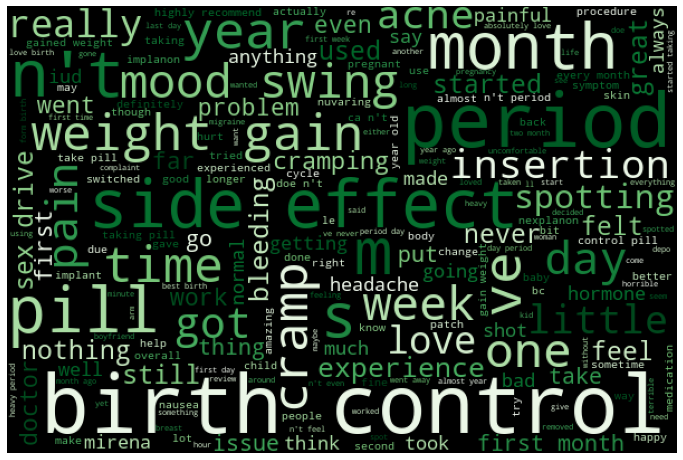

In [108]:
# word cloud of stopped words
plot_wordcloud(make_wordcloud(tokens_stopped_pos))

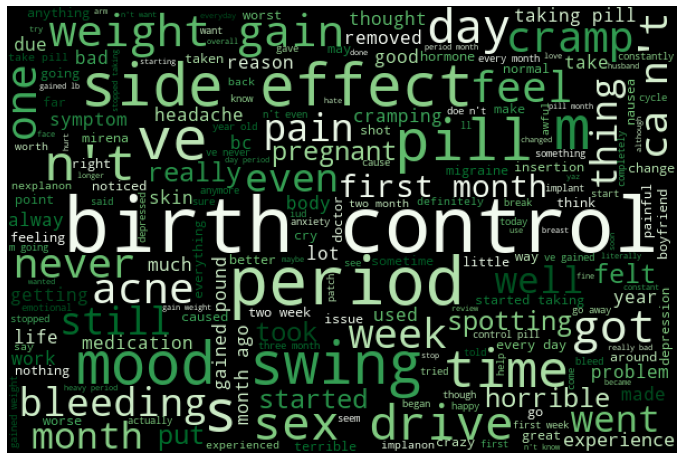

In [109]:
# word cloud of stopped words
plot_wordcloud(make_wordcloud(tokens_stopped_neg))

# rudimentary modeling

In [117]:
# split the data into target (sentiment) and predictor (text)
X, y = dfbc['review'], dfbc['sentiment']

# split the data into train and test sets
# set random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

## Plurality check

It will be instructive to recall the percentage of the plurality in the target feature (sentiment). Models should be evaluated in relation to this.

In [118]:
# save this value to compare to future model crossval scores
plurality_cv = round(y_train.value_counts(normalize=True)[1],4)
# show the sentiment breakdown
round(y_train.value_counts(normalize=True),4)

sentiment
1    0.5747
0    0.4253
Name: proportion, dtype: float64

In [122]:
y_pred_train = y_train.copy().apply(lambda x: 1)
train_acc = round(accuracy_score(y_pred_train, y_train),4)
y_pred_test = y_test.copy().apply(lambda x: 1)
test_acc = round(accuracy_score(y_pred_test, y_test),4)
print(
    'Plurality Calculation',
    '\n\nTraining Score: '+str(train_acc),
    '\nTest Score:     '+str(test_acc)
)

Plurality Calculation 

Training Score: 0.5747 
Test Score:     0.562


## Results function

We'll create a function that takes the pipeline we've created and displays only the results we're interested in.

In [123]:
def model_results(pipeline):
    # fit the pipeline to the training data
    pipeline.fit(X_train, y_train)
    # generate predictions for the test data
    y_pred = pipeline.predict(X_test)
    # display the training and test accuracy scores
    print(f"Training Score: {round(pipeline.score(X_train, y_train),4)} \
    \nTest Score:     {round(pipeline.score(X_test, y_test),4)}")
    
    # plot the normalized confusion matrix
    plot_confusion_matrix(estimator=pipeline, X=X_test, y_true=y_test, cmap='Greens', 
                          normalize='true', 
                          display_labels=['Non-positive', 'Positive'])

## Tokenizer function

We'll use what we developed during exploration to make a custom tokenizer function. This will perform all of the following:
- tokenize tweets
- remove accents and hashtags
- lemmatize tokens
- join "ipad" and "2" where appropriate

This tokenizer will *not* remove stopwords, as we may wish to vary our choice of stopwords in the models.

In [ ]:
# make tokenizer
def custom_tokenize(document):

    tokens = word_tokenize(','.join(document))
    
    # remove stop words
    tokens = [word for word in tokens if not word in stop_list]

    # instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()

    # lemmatize the list of words
    tokens_lemmatized = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens_lemmatized
    
    
    

    # instantiate tokenizer
    tokenizer = TweetTokenizer(
        preserve_case=False,
        strip_handles=True
    )

    # create list of tokens from data set
    tokens = tokenizer.tokenize(document)

    # remove hashtags and accents
    tokens = [unidecode(word) for word in tokens if not word.startswith('#')] + \
    [unidecode(word[1:]) for word in tokens if word.startswith('#')]
    
    # remove stop words
    tokens = [word for word in tokens if not word in stop_list]

    # instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()

    # lemmatize the list of words
    tokens_lemmatized = [lemmatizer.lemmatize(word) for word in tokens]

    # perform ipad fix
    tokens_lemmatized = ipad_fix(tokens_lemmatized)
    
    return tokens_lemmatized

## Naive Bayes (BASELINE MODEL)
### Rough model

Naive Bayes


/Users/stubbletrouble/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``', 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Training Score: 0.5761     
Test Score:     0.5623


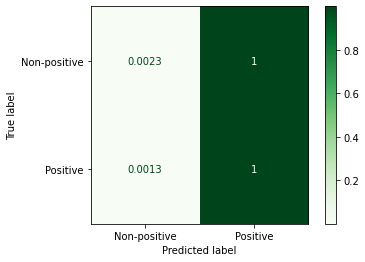

In [132]:
# Multinomial Naive Bayes

# create pipeline
pipeline_nb = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', MultinomialNB())
])
print('Naive Bayes')
# create model from pipeline and display results
model_results(pipeline_nb)

In [136]:
if do_grids == True:

    param_grid = {'clf__alpha': [0.001, 0.01, 0.1, 1]}
    gridsearch = GridSearchCV(pipeline_nb, param_grid=param_grid, 
                                  scoring='accuracy')

    gridsearch.fit(X_train, y_train)
    gridsearch.best_params_

/Users/stubbletrouble/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``', 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/stubbletrouble/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``', 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/stubbletrouble/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop wor

We'll use this alpha size in the tuned model.

### Tuned Naive Bayes

In [137]:
# Tuned Multinomial Naive Bayes

# create pipeline
pipeline_nb = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', MultinomialNB(alpha=0.1))
])
print('Naive Bayes')
# create model from pipeline and display results
model_results(pipeline_nb)

Naive Bayes


/Users/stubbletrouble/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``', 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


KeyboardInterrupt: 

# end